for backprop, keeping 50% of networks
for backprop_nd, keeping 80% of networks
for gating, keeping 100% of networks
for strong_attractor, keeping 100% of networks
for reshuffle, keeping 100% of networks
for inversion, keeping 100% of networks
for gating+reshuffle, keeping 100% of networks
for gating+inversion, keeping 100% of networks


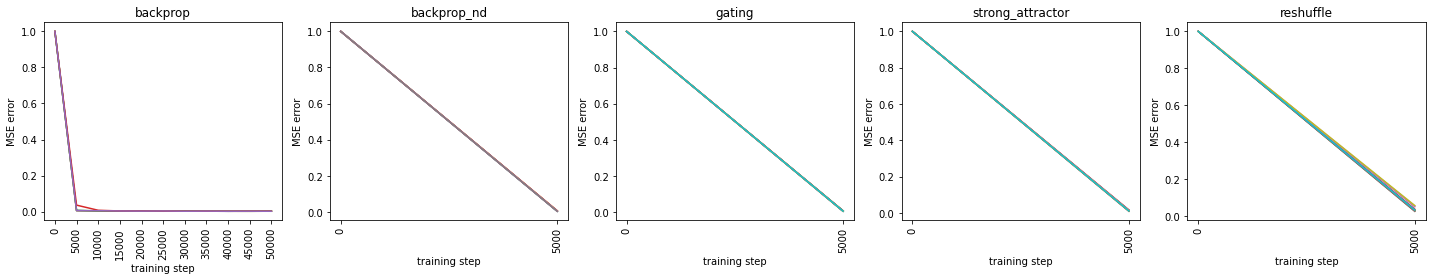

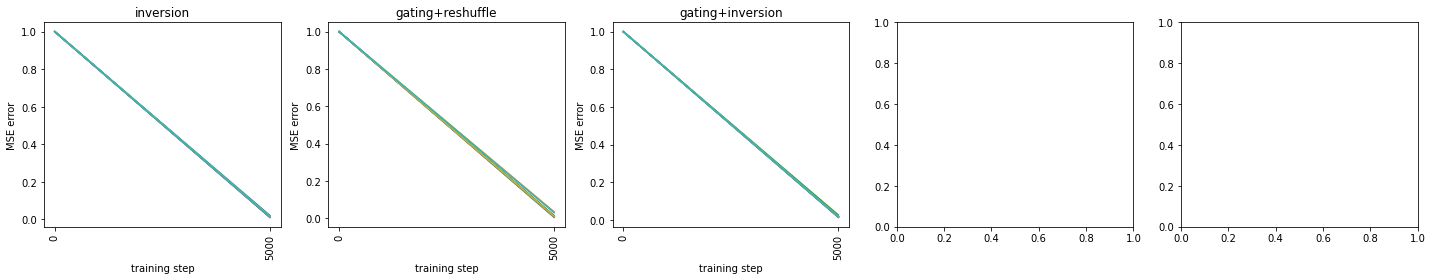

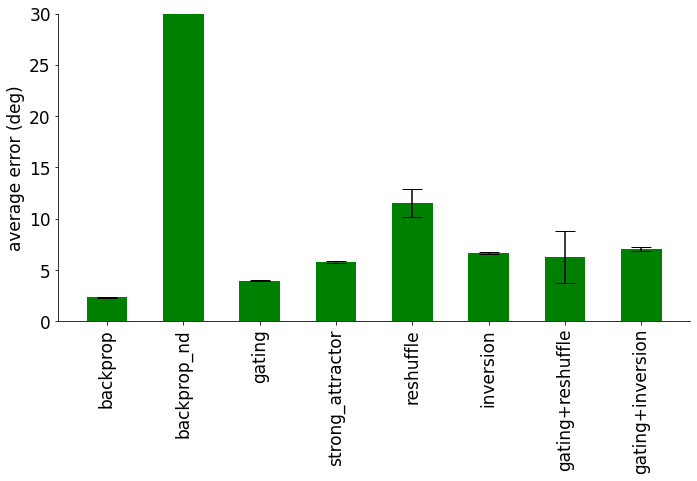

In [1]:
import numpy as np
import os
from netrep.metrics import LinearMetric
from netrep.metrics import GaussianStochasticMetric
import matplotlib.pyplot as plt
import seaborn as sns
import json, math
from scipy import stats

# Load all networks to study here
n_networks = 10
net_size = 180
all_networks = {
    "backprop": {
        "color": "#000000", # color of dots on the graph
        "names": [f"data/backpropCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)], # directories
        "indices": np.arange(0, 64, 16), # indices of trials to consider (here, only using 4 trials to match neural data)
        "display_name": "Backprop"
    },
    "backprop_nd": {
        "color": "gray",
        "names": [f"data/backpropCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp0.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "BP (WM)"
    },
    "gating": {
        "color": "#B41F24",  # color of dots on the graph
        "names": [f"data/hdgatingCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],  # directories
        "indices": np.arange(0, 64, 16),
        "display_name": "G"
    },
    "strong_attractor": {
        "color": "#009444",  # random color
        "names": [f"data/hdratioCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "SA"
    },
    "reshuffle": {
        "color": "#B3A032",
        "names": [f"data/hdreshuffle_fCTRNN_2DIR1O_dr{net_size}_n0.1_la0_sa130_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "R/T"
    },
    "inversion": {
        "color": "#3E4D99",
        "names": [f"data/hdinversionCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "I/T"
    },
    "gating+reshuffle": {
        "color": "#9A583F",
        "names": [f"data/hdgating_and_reshuffle_fCTRNN_2DIR1O_dr{net_size}_n0.1_la0_sa130_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "G+R/T"
    },
    "gating+inversion": {
        "color": "#9A3E84",
        "names": [f"data/hdgating_and_inversionCTRNN_2DIR1O_dr{net_size}_n0.1_la0_e1_dp1.0_r{i}" for i in range(n_networks)],
        "indices": np.arange(0, 64, 16),
        "display_name": "G+I/T"
    },
    "mendoza_halliday_et_al_2014": {
        "color": "orange",
        "names": ["neuraldata/new/diego_phd_mst_either_selective_zscored"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True,
        "display_name": "MST1"
    },
    "mendoza_halliday_et_al_2023": {
        "color": "orange",
        "names": ["neuraldata/new/diego_new_mst_either_selective_zscored"],
        "indices": np.array([0, 1, 2, 3]),
        "neural": True,
        "display_name": "MST2"
    }
}


# load information about every network
for network in list(all_networks.values()):
    if "neural" in network: continue
    network["errors"] = []
    network["metadatas"] = []
    indices_to_remove = []
    for i, name in enumerate(network["names"]):
        if not os.path.isfile(name+"/info.json"):
            print("FILE DOES NOT EXIST:", name)
            indices_to_remove.append(i)
            continue
        with open(name+"/info.json") as f: info = json.load(f)
        network["errors"].append((info["error_distractor"][2], info["error_nodistractor"][2]))
        network["metadatas"].append(info)
    for x in indices_to_remove[::-1]:
        del network['names'][x]
    

# filter to only use the networks where MSE < 15 deg (only those that converged)
for name, network in all_networks.items():
    if 'errors' in network:
        indices_to_remove = []
        for i, error in enumerate(network['errors']):
            if (name == "backprop_nd" and (error[1]>15 or math.isnan(error[1]))) or ((error[0]>15 or math.isnan(error[0])) and name !="backprop_nd"):
                indices_to_remove.append(i)
                
        print(f"for {name}, keeping {int((1-len(indices_to_remove)/len(network['names']))*100)}% of networks")
        for x in indices_to_remove[::-1]:
            del network['names'][x]
            del network['errors'][x]
            del network['metadatas'][x]

# show all errors through time, for an overview
row_count = 0  # Counter to track the number of plots in the current row
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # Create a row of 5 subplots
for network_name, network in all_networks.items():
    if "neural" in network: continue
    ax = axs[row_count]  # Select the subplot
    for name in network["names"]:
        with open(name+"/info.json") as f: 
            info = json.load(f)
        ax.plot(list(info["error_store_saved"].keys()), list(info["error_store_saved"].values()))
    ax.set_title(network_name)
    ax.set_xlabel("training step")
    ax.set_ylabel("MSE error")
    for label in ax.get_xticklabels(): label.set_rotation(90)
    row_count += 1
    if row_count >= 5:  # Reset if 5 plots in a row
        plt.tight_layout()
        plt.show()
        fig, axs = plt.subplots(1, 5, figsize=(20, 4))
        row_count = 0
plt.tight_layout()
plt.show()

# show all final errors of kept networks, for comparison
use_networks = [key for key in all_networks.keys() if "neural" not in all_networks[key] or not all_networks[key]["neural"]]
means = [np.mean(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
errors = [np.std(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
fig = plt.figure(figsize=(10, 7))
plt.rc('font', **{'family': 'DejaVu Sans', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
ax.bar(np.arange(1, len(use_networks)+1)*1.5, means, yerr=errors, align='center', alpha=1, ecolor='black', capsize=10, color="green")
plt.xticks(ticks=np.arange(1, len(use_networks)+1)*1.5, labels=use_networks)
plt.ylim(0, 30)
ax.set_ylabel('average error (deg)')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

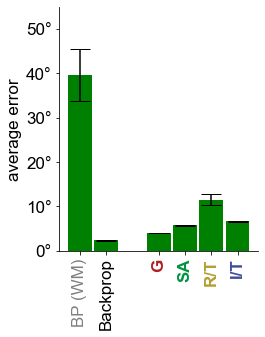

In [4]:
from matplotlib.ticker import FormatStrFormatter
# show all final errors of kept networks, for comparison
x_values = [1, 2, 4, 5, 6, 7]
use_networks = ['backprop_nd', 'backprop', 'gating', 'strong_attractor', 'reshuffle', 'inversion']
network_names = [all_networks[x]['display_name'] for x in use_networks]
network_colors = [all_networks[x]['color'] for x in use_networks]


#use_networks = ['backprop', None, 'gating', 'ratio', 'reshuffle_ad', 'inversion']
means = [np.mean(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]
errors = [np.std(np.array(all_networks[network]["errors"])[:, 0]) for network in use_networks]

fig = plt.figure(figsize=(4, 5))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 17})
ax = plt.subplot(1, 1, 1)
ax.bar(x_values, means, yerr=errors, align='center', width=.9, alpha=1, ecolor='black', capsize=10, color="green")
plt.xticks(ticks=x_values, labels=network_names)
plt.ylim(0, 55)
ax.set_ylabel('average error')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().set_xticklabels(ax.get_xticklabels(), rotation=90)
# Loop through the tick labels and set their colors
for i, ticklabel in enumerate(ax.get_xticklabels()):
    ticklabel.set_color(network_colors[i])
    if i>1: ticklabel.set_weight('bold')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d°'))
plt.tight_layout()
#plt.savefig('paper_figures/_solutions_errors.pdf', bbox_inches='tight')